<a href="https://colab.research.google.com/github/Hernanros/Ames-house-pricing/blob/master/House%20price%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/Hernanros/work_portfolio

fatal: destination path 'work_portfolio' already exists and is not an empty directory.


In [2]:
cd /content/work_portfolio/Predicting house prices

/content/work_portfolio/Predicting house prices


In [0]:
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import linear_model 
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

## Helper Functions

In [0]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

def plot_ecdf(x,y,xname):
    plt.plot(x,y,marker='.',linestyle='none')
    plt.xlabel(xname)
    plt.ylabel('Culmanative Probability')
    plt.show()
    
def compare_normality(var):
    np.random.seed(seed=42)
    x_norm,y_norm=ecdf(np.random.normal(loc=np.mean(var),scale=np.std(var),size=len(var)))
    x_var,y_var=ecdf(var)
    plt.plot(x_norm,y_norm,marker='.',linestyle='none',color='black')
    plt.plot(x_var,y_var,marker='.',linestyle='none',color='red')
    plt.xlabel('random distribution vs.'+ str(var.name) )
    plt.ylabel('Culmanative Probability')
    plt.legend({'norm':x_norm, 'price':str(var.name) })
    plt.show()
    
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmsle(model):
    rmsle = np.sqrt(np.log(-cross_val_score(model, X, y,
                                           scoring = 'neg_mean_squared_error',
                                           cv=kfolds)))
    return(rmsle)
    
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
    

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

# Data loading

In [0]:
test=pd.read_csv('Data/test.csv',index_col='Id')
train=pd.read_csv('Data/train.csv',index_col='Id')
target=train.SalePrice

# EDA

### Understanding the depentent variable

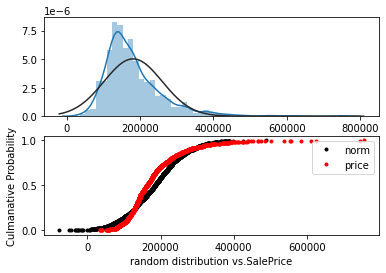

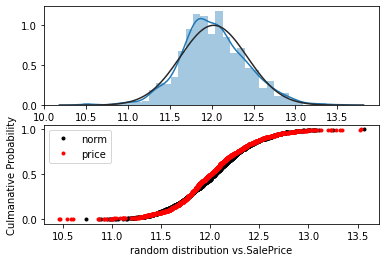

In [6]:
plt.scatter(train.GrLivArea,train.SalePrice)
train=train[train['GrLivArea']<4500]
plt.scatter(train.GrLivArea,train.SalePrice)

plt.subplot(2,1,1)
sns.distplot(target,fit=stats.norm)
plt.subplot(2,1,2)
compare_normality(target)

plt.figure()
plt.subplot(2,1,1)
sns.distplot(np.log1p(target),fit=stats.norm)
plt.subplot(2,1,2)
compare_normality(np.log1p(target))
plt.show()


we can see that the sale price variable is pretty clearly taken from a log-normal distribution, so we will convert it to a logarithmic scale

In [0]:
target=np.log1p(target)


# Feature engeniering

In [8]:
#concatanating test and train: df
df=pd.concat([train,test], sort=False)

#Imputing NA
null_sum=df.isna().sum().sort_values(ascending=False)
null_sum=null_sum[null_sum!=0]
null_sum

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
GarageCars         1
BsmtFinSF2         1
Exterior2nd        1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
Exterior1st        1
KitchenQual        1
SaleType           1
Electrical         1
dtype: int64

### handeling garage variables: 
1. imputing variables to the 2 variables where there is a garage but rest of the variabls are NA
2. replacing NA with 0


In [9]:
df[['GarageType','GarageYrBlt','GarageFinish','GarageCond','GarageQual']][df['GarageType'].notna( ) & df['GarageQual'].isna() ]

,GarageType,GarageYrBlt,GarageFinish,GarageCond,GarageQual
Id,,,,,
2127,Detchd,NaN,NaN,NaN,NaN
2577,Detchd,NaN,NaN,NaN,NaN


In [10]:
df[['GarageQual','GarageFinish','GarageCond']].groupby(df['GarageType']).agg(pd.Series.mode)


,GarageQual,GarageFinish,GarageCond
GarageType,,,
2Types,TA,Unf,TA
Attchd,TA,RFn,TA
Basment,TA,Unf,TA
BuiltIn,TA,Fin,TA
CarPort,TA,Unf,TA
Detchd,TA,Unf,TA


In [0]:
df['GarageFinish'][df['GarageFinish'].isna() & df['GarageType'].notna()]='Unf' 
df['GarageCond'][df['GarageCond'].isna() & df['GarageType'].notna()]='TA' 
df['GarageQual'][df['GarageQual'].isna() & df['GarageType'].notna()]='TA' 
df['GarageYrBlt'][df['GarageYrBlt'].isna() & df['GarageType'].notna()]=df['YearRemodAdd']
df[['GarageType','GarageYrBlt','GarageFinish','GarageCond','GarageQual']]=df[['GarageType','GarageYrBlt','GarageFinish','GarageCond','GarageQual']].fillna(0)


In [12]:
df[['GarageCond','GarageQual','GarageArea','GarageCars']][df['GarageCars'].isna()]


,GarageCond,GarageQual,GarageArea,GarageCars
Id,,,,
2577,TA,TA,NaN,NaN


In [13]:
df[['GarageCond','GarageQual','GarageArea','GarageCars']].groupby(['GarageCond','GarageQual']).mean()


GarageArea  GarageCars
GarageCond GarageQual                        
0          0             0.000000    0.000000
Ex         Ex          612.000000    1.000000
           Gd          576.000000    2.000000
Fa         Fa          316.743590    1.384615
           Po          195.000000    1.000000
           TA          356.470588    1.411765
Gd         Gd          562.500000    2.000000
           TA          604.666667    2.000000
Po         Fa          331.625000    1.500000
           Po          301.000000    1.000000
           TA          240.500000    1.000000
TA         Ex          840.000000    3.000000
           Fa          342.584416    1.324675
           Gd          666.647059    1.941176
           TA          507.963643    1.898749

In [0]:
df['GarageCars']=df['GarageCars'].fillna(2)
df['GarageArea']=df['GarageArea'].fillna(508)

df['HasGarage']=df['GarageArea'].apply(lambda x: 0 if x==0 else 1)

### handeling BSMT variables


In [15]:
df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtFinType2'].isna() &df['BsmtFinType1'].notna()]


,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
Id,,,,,
333,No,TA,Gd,NaN,GLQ


In [16]:
df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']].groupby('BsmtFinType1').agg(pd.Series.mode)


,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2
BsmtFinType1,,,,
ALQ,No,TA,TA,Unf
BLQ,No,TA,TA,Unf
GLQ,No,TA,Gd,Unf
LwQ,No,TA,TA,Unf
Rec,No,TA,TA,Unf
Unf,No,TA,TA,Unf


In [0]:
df['BsmtExposure'][df['BsmtFinType2'].isna() &df['BsmtFinType1'].notna()]=df['BsmtExposure'].fillna('No')
df['BsmtQual'][df['BsmtFinType2'].isna() &df['BsmtFinType1'].notna()]=df['BsmtQual'].fillna('Gd')
df['BsmtFinType2'][df['BsmtFinType2'].isna() &df['BsmtFinType1'].notna()]=df['BsmtFinType2'].fillna('Unf')

In [18]:
df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtQual'].isna() &df['BsmtFinType1'].notna()]


,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
Id,,,,,
2218,No,Fa,NaN,Unf,Unf
2219,No,TA,NaN,Unf,Unf


In [0]:

df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']].groupby(['BsmtFinType1','BsmtFinType2']).agg(pd.Series.mode)
df['BsmtQual'][df['BsmtQual'].isna() &df['BsmtFinType1'].notna()]=df['BsmtQual'].fillna('TA')


In [20]:
df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtCond'].isna() &df['BsmtFinType1'].notna()]


,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
Id,,,,,
2041,Mn,NaN,Gd,Rec,GLQ
2186,No,NaN,TA,Unf,BLQ
2525,Av,NaN,TA,Unf,ALQ


In [0]:
df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']].groupby(['BsmtQual','BsmtFinType1']).agg(pd.Series.mode)
df['BsmtCond']=df['BsmtCond'].fillna('TA')

In [22]:
df[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtExposure'].isna() &df['BsmtFinType1'].notna()]


,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
Id,,,,,
949,NaN,TA,Gd,Unf,Unf
1488,NaN,TA,Gd,Unf,Unf
2349,NaN,TA,Gd,Unf,Unf


In [0]:
df[['BsmtExposure','BsmtQual','BsmtFinType1']].groupby(['BsmtQual','BsmtFinType1']).agg(pd.Series.mode)
df['BsmtExposure'][df['BsmtExposure'].isna() &df['BsmtFinType1'].notna()]=df['BsmtExposure'].fillna('No')


In [24]:
df[['TotalBsmtSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtUnfSF'].isna()]


,TotalBsmtSF,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
Id,,,,,
2121,NaN,TA,NaN,NaN,NaN


In [25]:
df[['TotalBsmtSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtFullBath'].isna()]
df[['TotalBsmtSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']][df['BsmtHalfBath'].isna()]

,TotalBsmtSF,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
Id,,,,,
2121,NaN,TA,NaN,NaN,NaN
2189,0.0,TA,NaN,NaN,NaN


In [0]:
bsmt_var=['BsmtHalfBath','TotalBsmtSF','BsmtFullBath','BsmtExposure','BsmtUnfSF','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFinSF1','BsmtFinSF2']
for var in bsmt_var:
    df[var]=df[var].fillna(0)

df['HasBsmt']=df['TotalBsmtSF'].apply(lambda x: 0 if x==0 else 1)

### Other variables

In [27]:
df['KitchenQual'].groupby(df['OverallQual']).agg(pd.Series.mode)


OverallQual
1     Fa
2     TA
3     TA
4     TA
5     TA
6     TA
7     Gd
8     Gd
9     Ex
10    Ex
Name: KitchenQual, dtype: object

In [0]:
df['OverallQual'][df['KitchenQual'].isna()]
df['KitchenQual']=df['KitchenQual'].fillna('TA')

df.Electrical=df.Electrical.fillna(df.Electrical.value_counts()[0])
df.Exterior1st=df.Exterior1st.fillna(df.Exterior1st.value_counts()[0])
df.Exterior2nd=df.Exterior2nd.fillna(df.Exterior2nd.value_counts()[0])
df.SaleType=df.SaleType.fillna(df.SaleType.value_counts()[0])
df.Utilities=df.Utilities.fillna(df.Utilities.value_counts()[0])
df.Functional=df.Functional.fillna(df.Functional.value_counts()[0])

In [29]:
df[['Neighborhood','MSZoning']].groupby('Neighborhood').agg(pd.Series.mode)


,MSZoning
Neighborhood,
Blmngtn,RL
Blueste,RM
BrDale,RM
BrkSide,RM
ClearCr,RL
CollgCr,RL
Crawfor,RL
Edwards,RL
Gilbert,RL


In [0]:
df.loc[2905,'MSZoning']='RL'
df.MSZoning=df.MSZoning.fillna('RM')

In [0]:
df['Fireplaces'][df['FireplaceQu'].isna() & df['Fireplaces']!=0]
df['Fireplaces']=df['Fireplaces'].fillna(0)
df['FireplaceQu']=df['FireplaceQu'].fillna(0)

df['HasFireplaces']=df['Fireplaces'].apply(lambda x: 0 if x==0 else 1)

df['MiscFeature']=df['MiscFeature'].fillna(0) 
df=df.rename(columns = {'MiscFeature':'HasMiscFeature'})
df['HasMiscFeature']=df['HasMiscFeature'].apply(lambda x: 0 if x==0 else 1)

df['PoolQC'][df['PoolQC'].isna() & df['PoolArea']!=0]
df['PoolQC']=df['PoolQC'].fillna(0)

df['HasPool']=df['PoolArea'].apply(lambda x: 0 if x==0 else 1)
        
df['Fence']=df['Fence'].fillna(0)
df['HasFence']=df['Fence'].apply(lambda x: 0 if x==0 else 1)

df['Alley']=df['Alley'].fillna(0)
df['HasAlleyAccsess']=df['Alley'].apply(lambda x: 0 if x==0 else 1)
        

In [0]:
df[['LotFrontage','Neighborhood']][df.LotFrontage.isna()]
lotneigh=df.LotFrontage.groupby(df.Neighborhood).mean()

for id in df[['LotFrontage','Neighborhood']][df.LotFrontage.isna()].index:
    neigh=df.loc[id,'Neighborhood']
    df.loc[id,'LotFrontage']=lotneigh[neigh]

In [33]:
df.MasVnrArea.value_counts().sort_values()


217.0       1
760.0       1
229.0       1
470.0       1
348.0       1
         ... 
216.0      12
176.0      13
200.0      13
120.0      15
0.0      1738
Name: MasVnrArea, Length: 442, dtype: int64

In [35]:
df[['MasVnrType','MasVnrArea']][df.MasVnrType.isna() & df.MasVnrArea.notna()]='BrkFace'
df.MasVnrType=df.MasVnrType.fillna('None')
df.MasVnrArea=df.MasVnrArea.fillna(0)

null_sum=df.isna().sum().sort_values(ascending=False)
null_sum=null_sum[null_sum!=0]
null_sum

SalePrice    1459
dtype: int64

### Seperating Categorical features and nums


In [0]:
nums=df.select_dtypes(np.number)
categories=df.select_dtypes(exclude=np.number)

### Factorization

In [37]:
nums.columns
fake_nums=['HasFireplaces','GarageYrBlt','MSSubClass','HasMiscFeature','MoSold','YrSold', 'HasGarage', 'HasBsmt', 'HasPool', 'HasFence', 'HasAlleyAccsess']
fakes=nums[fake_nums]
fakes=fakes.astype('object',copy=False)
nums=nums.drop(fake_nums,axis=1)
categories=pd.concat([categories,fakes],axis=1)
categories=categories.astype('category',copy=False)
categories.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MSZoning         2917 non-null   category
 1   Street           2917 non-null   category
 2   Alley            2917 non-null   category
 3   LotShape         2917 non-null   category
 4   LandContour      2917 non-null   category
 5   Utilities        2917 non-null   category
 6   LotConfig        2917 non-null   category
 7   LandSlope        2917 non-null   category
 8   Neighborhood     2917 non-null   category
 9   Condition1       2917 non-null   category
 10  Condition2       2917 non-null   category
 11  BldgType         2917 non-null   category
 12  HouseStyle       2917 non-null   category
 13  RoofStyle        2917 non-null   category
 14  RoofMatl         2917 non-null   category
 15  Exterior1st      2917 non-null   category
 16  Exterior2nd      2917 non-null   category


###Getting rid of unvaried columns

In [38]:
mode_freq={}
for var in df.columns:
    freq=df[var].value_counts()[df[var].mode()[0]]/len(df[var])
    mode_freq[var]=freq
freq=pd.Series(mode_freq,index=mode_freq.keys())
unvaried=freq[freq>=0.97].drop(['HasBsmt','HasPool'])

df['HasBsmt'].value_counts()

1    2838
0      79
Name: HasBsmt, dtype: int64

In [0]:
df=df.drop(unvaried.index,axis=1)


###unifing repetative fetures


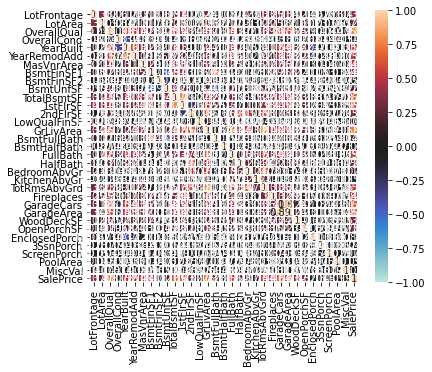

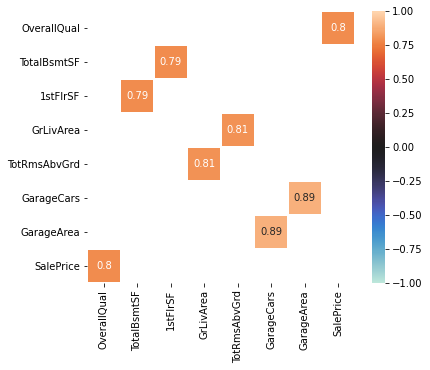

In [40]:

inner=nums.corr()
high_colinear=inner[inner>.75]
high_colinear.replace(to_replace=1,value=np.nan,inplace=True)
high_colinear=high_colinear.dropna(how='all',axis=1).dropna(how='all',axis=0)
colin_pairs=[]
for column in high_colinear.columns:
    row=high_colinear[column].idxmax()
    colin_pairs.append([row,column])

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(inner, annot=True, xticklabels=inner.columns, 
            yticklabels=inner.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(high_colinear, annot=True, xticklabels=high_colinear.columns, 
            yticklabels=high_colinear.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)


vars=sorted(list(df.columns))
df['TotalSF']=df['1stFlrSF']+df['2ndFlrSF']+df['GrLivArea']+df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalPorchSF']=df['OpenPorchSF']+df['EnclosedPorch']+df['ScreenPorch']
df['TotalBath']=df['BsmtFullBath']+(df['BsmtHalfBath']*.5)+df['FullBath']+(df['HalfBath']*.5)
df=df.drop(['EnclosedPorch','ScreenPorch','OpenPorchSF'],axis=1)
df=df.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],axis=1)
df=df.drop(['GarageArea','1stFlrSF'],axis=1)

###numeric values Skewness exploration


In [41]:
skewness=nums.skew(axis=0).sort_values(ascending=False)
skewd_list=skewness[abs(skewness)>(0.5)].index
skewd=nums[skewd_list]
skewd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MiscVal        2917 non-null   int64  
 1   PoolArea       2917 non-null   int64  
 2   LotArea        2917 non-null   int64  
 3   LowQualFinSF   2917 non-null   int64  
 4   3SsnPorch      2917 non-null   int64  
 5   KitchenAbvGr   2917 non-null   int64  
 6   BsmtFinSF2     2917 non-null   float64
 7   EnclosedPorch  2917 non-null   int64  
 8   ScreenPorch    2917 non-null   int64  
 9   BsmtHalfBath   2917 non-null   float64
 10  MasVnrArea     2917 non-null   float64
 11  OpenPorchSF    2917 non-null   int64  
 12  SalePrice      1458 non-null   float64
 13  WoodDeckSF     2917 non-null   int64  
 14  1stFlrSF       2917 non-null   int64  
 15  GrLivArea      2917 non-null   int64  
 16  LotFrontage    2917 non-null   float64
 17  BsmtFinSF1     2917 non-null   float64
 18  BsmtUnfS

In [42]:
for var in skewd.columns:
    skewd[var]=np.log1p(skewd[var])
    df[var]=skewd[var]
    print(var+' transformed')        
log_skewness=skewd.skew(axis=0).sort_values(ascending=False)


MiscVal transformed
PoolArea transformed
LotArea transformed
LowQualFinSF transformed
3SsnPorch transformed
KitchenAbvGr transformed
BsmtFinSF2 transformed
EnclosedPorch transformed
ScreenPorch transformed
BsmtHalfBath transformed
MasVnrArea transformed
OpenPorchSF transformed
SalePrice transformed
WoodDeckSF transformed
1stFlrSF transformed
GrLivArea transformed
LotFrontage transformed
BsmtFinSF1 transformed
BsmtUnfSF transformed
2ndFlrSF transformed
TotRmsAbvGrd transformed
Fireplaces transformed
HalfBath transformed
TotalBsmtSF transformed
BsmtFullBath transformed
OverallCond transformed
YearBuilt transformed


In [0]:
#Getting rid of unvaried columns
mode_freq={}
for var in df.columns:
    freq=df[var].value_counts()[df[var].mode()[0]]/len(df[var])
    mode_freq[var]=freq
freq=pd.Series(mode_freq,index=mode_freq.keys())
unvaried=freq[freq>=0.97].drop(['HasBsmt','HasPool'])

df=df.drop(unvaried.index,axis=1)

#creating dummies
categories1=df.select_dtypes(exclude=np.number)
nums1=df.select_dtypes(np.number)
for var in list(categories1.columns):
    df[var]=df[var].astype('category',copy=False)
df[categories1.columns].dtypes
df1=pd.get_dummies(df)

train=df1.loc[:len(target),:]
test=df1.loc[len(target)+1:,:]

# Outliers detection

OLS stands for ordinary least squares. it analyzes the array and returns an outliers detection
ols = sm.OLS(endog = y, exog = X)
fit=ols.fit()

There are several outlier test that are part o statmodels.OLS.outlier_test(), bonf(p) is the default.
it anyalizes the probability of each indice in the array to not be an outlier, and returns the p-values
we are going stamp out each data point that it's probability of NOT being an outlier is smaller than alpha (0.01)


In [0]:
ols = sm.OLS(endog = y, exog = X)
fit=ols.fit()
OE= fit.outlier_test()['bonf(p)']
liers_alpha=0.001
liers=OE[OE<liers_alpha]
drop_them=list(liers.index)
drop_them
train=train.drop(drop_them,axis=0)
y=y.drop(drop_them,axis=0)


# Regression Models

In [0]:
X=train.drop('SalePrice',axis=1)
y=train.SalePrice

X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)


kfolds = KFold(n_splits=10, shuffle=True, random_state=23)
lm=linear_model.LinearRegression()
scaler=preprocessing.RobustScaler()
ridge=linear_model.Ridge(alpha=6.099999999999998)
lasso=linear_model.Lasso(alpha=0.00032, max_iter=10e5)
net=linear_model.ElasticNetCV()
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


r_alphas ={'alpha': [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]}
r_alphas2={'alpha': np.arange(3, 10, 0.5)}
r_alphas3={'alpha': np.arange(5.5, 6.5, 0.1)}
ridge_CV=GridSearchCV(ridge,r_alphas3 ,cv=10)
ridge_CV=ridge_CV.fit(X_train,y_train)
ridge_pred=ridge_CV.predict(X_test)
print('Ridge Regression score: '+str(ridge_CV.score(X_test,y_test)))
print('RIgge Regression root mean square error: '+str(rmsle(y_test,ridge_pred)))

l_alphas={'alpha':[0.000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1]}
l_alphas1={'alpha':np.arange(0.0003,0.0004,0.00001)}
lasso_CV=GridSearchCV(lasso,l_alphas1 ,cv=10)
lasso_CV=lasso_CV.fit(X_train,y_train)
lasso_pred=lasso_CV.predict(X_test)
print('Lasso Regression score: '+str(lasso_CV.score(X_test,y_test)))
print('Lasso Regression root mean square error: '+str(rmsle(y_test,lasso_pred)))


net_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1]
net_alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
net=linear_model.ElasticNetCV(l1_ratio=net_ratio,alphas=net_alphas ,cv=10)
net=net.fit(X_train,y_train)
net_pred=net.predict(X_test)
print('Elastic net score: '+str(net.score(X_test,y_test)))
print('Elastic net root mean square error: '+str(rmsle(y_test,net_pred)))

lasso_pred=pd.Series(lasso_pred)
net_pred=pd.Series(net_pred)
ridge_pred=pd.Series(ridge_pred)
X2=[ridge_pred,lasso_pred,net_pred] 
X2=pd.concat([ridge_pred,lasso_pred,net_pred],axis=1)
X2=X2.rename(columns={0:'lasso_pred',1:'net_pred',2:'ridge_pred'})


GBoost=GBoost.fit(X_train,y_train)
print('GBoost root mean square error: '+str(GBoost.score(X_test,y_test)))
gboost_pred=GBoost.predict(X_test)
print('GBoost root mean square error: '+str(rmsle(y_test,gboost_pred)))

averaged_models = AveragingModels(models = (net, ridge_CV, lasso_CV,GBoost))
averaged_models.fit(X_train,y_train)
ave_pred=averaged_models.predict(X_test)
print('Model averages score: '+str(averaged_models.score(X_test,y_test)))
print('Model averages error: '+str(rmsle(y_test,ave_pred)))
meta_ave=ridge_pred*0.25+lasso_pred*.25+net_pred*.25+gboost_pred*.25
rmsle(y_test,meta_ave)

xgbreg=xgb.XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=42, reg_alpha=0.00006)

xgbreg=xgb.XGBRegressor(objective= 'reg:linear',seed=42)
grid_params={
        'learning_rate':[0.01,0.05,0.1,0.3],
        'n_estimators':np.arange(1000,6000,1000),
        'max_depth':[4,5,6],
        'reg_alpha':[0,0.000001,0.00001,0.0001,.001,.01]}
grid_search=GridSearchCV(cv=4,estimator=xgbreg,param_grid=grid_params,scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)
print('best parms: '+grid_search.best_params_)
print('best score: '+grid_search.best_score_)
xgbreg=xgb.XGBRegressor(objective= 'reg:linear',seed=42)
xgbreg=xgbreg.fit(X_train,y_train)
xgbreg_pred=xgbreg.predict(X_test)
print('xgbreg score: '+str(xgbreg.score(X_test,y_test)))
print('xbgreg root mean square error ' +str(rmsle(y_test,xgbreg_pred)))

Ridge Regression score: 0.9311520209824096
RIgge Regression root mean square error: 0.1050041487731915
Lasso Regression score: 0.933599050695428
Lasso Regression root mean square error: 0.10312121102504145
Elastic net score: 0.9335366399719458
Elastic net root mean square error: 0.10316966182193718
GBoost root mean square error: 0.9186082504197415
GBoost root mean square error: 0.11416975063360812
Model averages score: 0.9349994986485279
Model averages error: 0.1020279624437107
[15:09:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:40

## Expirements in ensemble methods


In [0]:
from mlxtend.regressor import StackingCVRegressor

stack = StackingCVRegressor(regressors=(ridge_CV,lasso_CV,net,GBoost,averaged_models,xgbreg),meta_regressor=xgbreg,
                               use_features_in_secondary=True)
stack = stack.fit(X_train,y_train)
stackX = np.array(X_train)
stacky = np.array(y_train)
stack = stack.fit(stackX, stacky)
stack_pred=stack.predict(np.array(X_test))
print('Stacked Model averages score: '+str(stack.score(np.array(X_test),np.array(y_test))))
print('Stacked Model averages error: '+str(rmsle(y_test,stack_pred)))

test=test.drop('SalePrice',axis=1)
SalePrice=stack.predict(np.array(test))
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_only.csv',index=False)

#%%
#blending
meta_ave=ridge_pred*0.13+lasso_pred*.13+net_pred*.13+gboost_pred*.13+xgbreg_pred*.13+stack_pred*.35
rmsle(y_test,meta_ave)

meta_ave2=(ridge_pred+lasso_pred+net_pred+gboost_pred+xgbreg_pred+stack_pred)/6
rmsle(y_test,meta_ave2)

#%%
final_pred=(ridge_CV.predict(test)*.13
            +lasso_CV.predict(test)*.13
            +net.predict(test)*.13
            +GBoost.predict(test)*.13
            +xgbreg.predict(test)*.13
            +stack.predict(np.array(test))*.35)

SalePrice=final_pred
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_all.csv',index=False)
#sub score: 0.11438 (303/4465, 94th percent)

final_pred=(ridge_CV.predict(test)
            +lasso_CV.predict(test)
            +net.predict(test)
            +GBoost.predict(test)
            +xgbreg.predict(test)
            +stack.predict(np.array(test)))/6

SalePrice=final_pred
SalePrice=np.expm1(SalePrice)
ID=pd.Series(test.index)
Submission=pd.DataFrame({'Id': test.index, 'SalePrice': SalePrice})
Submission.to_csv('submission_stack_all.csv',index=False)
#sub score: .11497, 359/4465 , 92nd percent!